Loading dataset from Resume.csv...
Dataset Loaded Successfully!

First 5 rows:
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  

Columns in dataset: Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')

Using Text Column: Resume_html
Using Label Colu

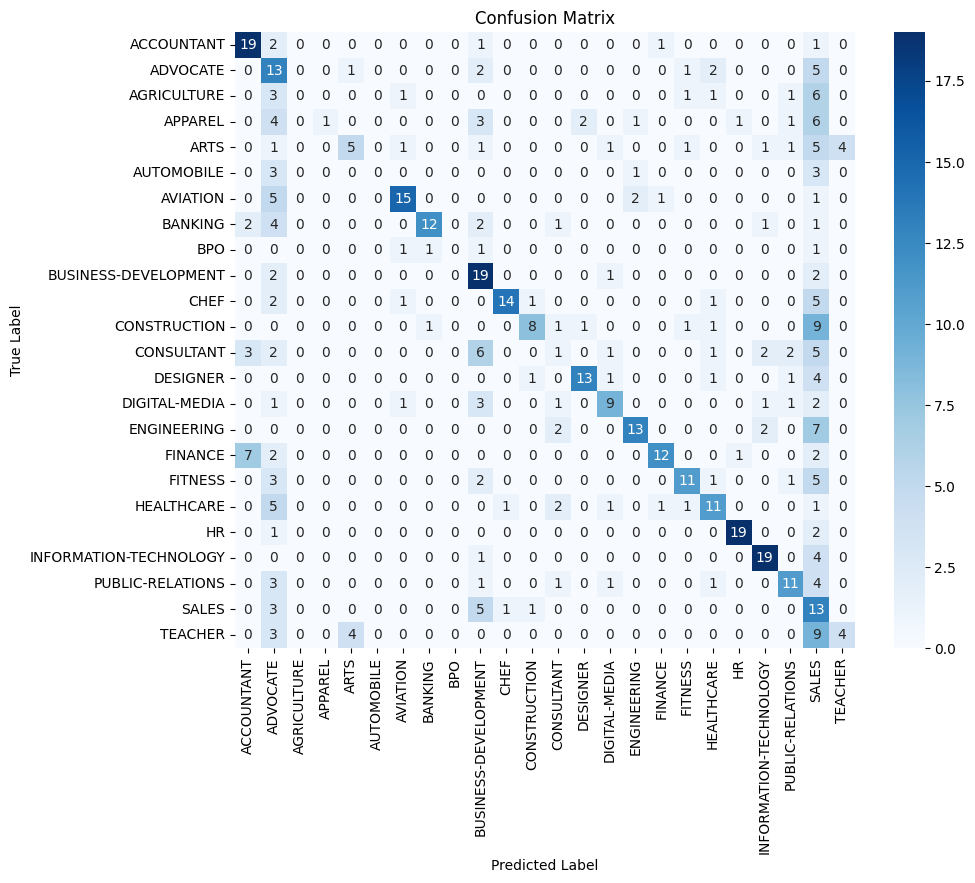


Generating Micro-averaged ROC Curve...


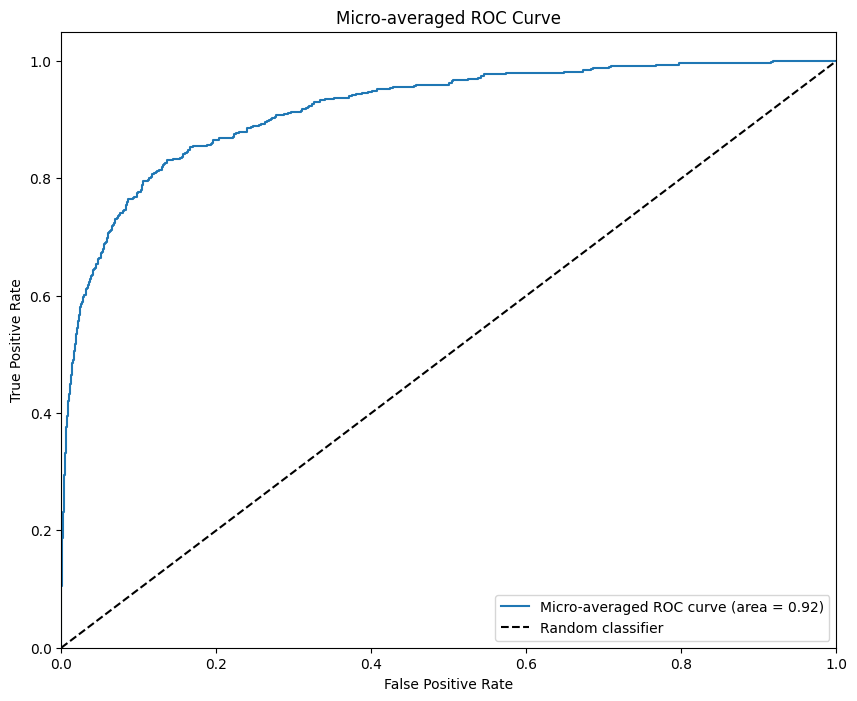


Generating Micro-averaged Precision-Recall Curve...


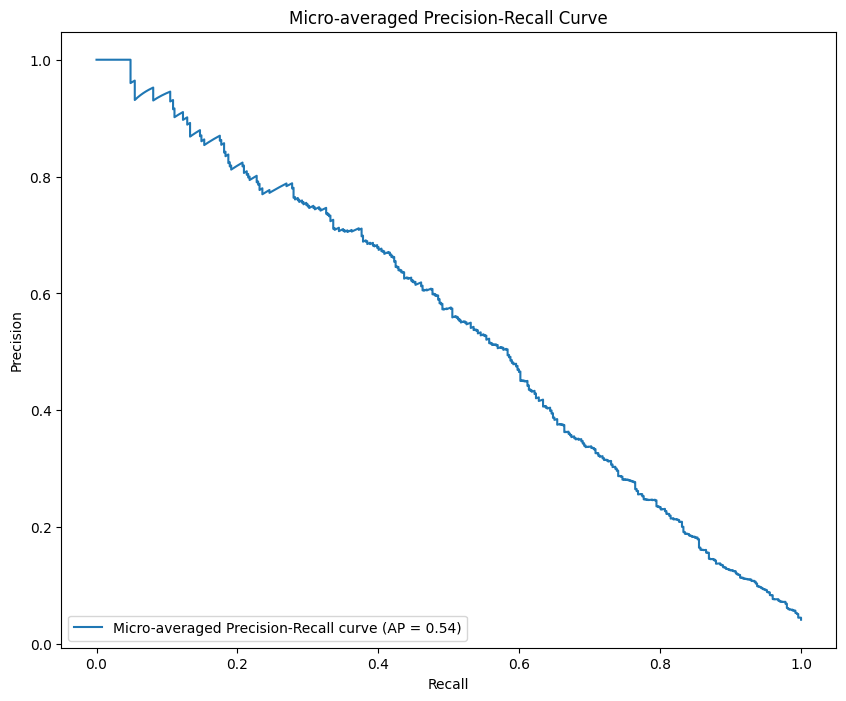

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load the dataset from Resume.csv
print("Loading dataset from Resume.csv...")
file_path = 'Resume.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}. Please make sure 'Resume.csv' is uploaded.")

df = pd.read_csv(file_path)

print("Dataset Loaded Successfully!\n")
print("First 5 rows:")
print(df.head())

print("\nColumns in dataset:", df.columns)

# 2. Robust Column Detection
text_column = None
label_column = None

for col in df.columns:
    if "resume" in col.lower():
        text_column = col
    if "category" in col.lower():
        label_column = col

if text_column is None or label_column is None:
    raise Exception("Could not detect 'Resume' or 'Category' column! Please ensure your CSV has these columns.")

print("\nUsing Text Column:", text_column)
print("Using Label Column:", label_column)

# 3. Split the DataFrame into features (X) and target (y)
X = df[text_column]
y = df[label_column]

# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 5. Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# 6. Fit the TfidfVectorizer on X_train and transform both X_train and X_test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print("\nTF-IDF vectorization complete.")

# 7. Initialize an SVC classifier with probability=True
svc_model = SVC(kernel='linear', probability=True, random_state=42)

# 8. Train the SVC model
svc_model.fit(X_train_tfidf, y_train)
print("SVC model training complete.")

# 9. Make predictions on the transformed X_test
y_pred = svc_model.predict(X_test_tfidf)

# 10. Get probability estimates for the X_test samples
y_proba = svc_model.predict_proba(X_test_tfidf)

# 11. Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# 12. Calculate and display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
class_names = sorted(y.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 13. Initialize a LabelBinarizer and fit on the full target variable y
label_binarizer = LabelBinarizer()
label_binarizer.fit(y)

# 14. Transform y_test using the fitted LabelBinarizer
y_test_binarized = label_binarizer.transform(y_test)

# 15. Micro-averaged ROC Curve
print("\nGenerating Micro-averaged ROC Curve...")

fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-averaged ROC curve (area = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-averaged ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 16. Micro-averaged Precision-Recall Curve
print("\nGenerating Micro-averaged Precision-Recall Curve...")

precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized.ravel(), y_proba.ravel())
avg_precision_micro = average_precision_score(y_test_binarized, y_proba, average='micro')

plt.figure(figsize=(10, 8))
plt.plot(recall_micro, precision_micro, label=f'Micro-averaged Precision-Recall curve (AP = {avg_precision_micro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-averaged Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()